## Import CSV Data into Pandas DataFrame

- Historical Dataset -> Dataset from 2012 to 2024
- 2024 Dataset with more information about the single year

In [1]:
# Imports
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt


# Files config
CSV_HISTORICO = 'datasets/inv-superficie-viniedos-2012-2024-cleaned.csv'
CSV_TYPES_2024 =  'datasets/inv-superficie-id-2024-cleaned.CSV'
SQLITE_DB = 'vinedos_argentina.db'

# Read CSV
try:
    df_historico = pd.read_csv(CSV_HISTORICO)
except FileNotFoundError:
    print(f"Error: El archivo {CSV_HISTORICO} no se encontró.")
    df_historico = pd.DataFrame()  # Empty DataFrame in case of Error

try:
    df_2024 = pd.read_csv(CSV_TYPES_2024)
except FileNotFoundError:
    print(f"Error: El archivo {CSV_TYPES_2024} no se encontró.")
    df_2024 = pd.DataFrame()  # Empty DataFrame in case of Error
    

## Data Cleaning
The Data was pre-cleaning in google sheets.
- Check for nulls and eliminate them
- Check for data types
- Check for duplicates and eliminate them


In [2]:
df_historico.info()
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9052 entries, 0 to 9051
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anio                 9052 non-null   int64  
 1   provincia_id         9052 non-null   int64  
 2   provincia_nombre     9052 non-null   object 
 3   departamento_id      9052 non-null   int64  
 4   departamento_nombre  9052 non-null   object 
 5   localidad_id         9052 non-null   object 
 6   localidad_nombre     9052 non-null   object 
 7   superficie_ha        9052 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 565.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86687 entries, 0 to 86686
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anio                 86687 non-null  int64  
 1   provincia_id         86687 non-null  int64  
 2   provincia_nombre

In [3]:
df_historico.describe()

,anio,provincia_id,departamento_id,superficie_ha
count,9052.000000,9052.000000,9052.000000,9052.000000
mean,2018.188688,49.077773,49158.154220,310.625124
std,3.734826,19.506578,19478.158267,706.557184
min,2012.000000,6.000000,6035.000000,0.006000
25%,2015.000000,46.000000,46049.000000,4.570000
50%,2018.000000,50.000000,50091.000000,33.914000
75%,2021.000000,66.000000,66014.000000,232.547500
max,2024.000000,90.000000,90112.000000,7076.920000


In [4]:
df_2024.describe()

,anio,provincia_id,departamento_id,anio_plantacion,superficie_plantada
count,86687.0,86687.000000,86687.000000,86687.000000,86687.000000
mean,2024.0,52.538651,52616.834762,1989.769539,2.282679
std,0.0,11.529556,11522.816727,22.947292,3.752940
min,2024.0,6.000000,6035.000000,1862.000000,0.000000
25%,2024.0,50.000000,50056.000000,1972.000000,0.500000
50%,2024.0,50.000000,50098.000000,1998.000000,1.240000
75%,2024.0,50.000000,50119.000000,2008.000000,2.625000
max,2024.0,90.000000,90112.000000,2024.000000,123.200000


## Check for planted_area distribution in both datasets

As we can see, most of the owners have a few planted areas, but there are some of them with more than 7,000 ha in the historical data. In this case, we are not going to treat them as outliers because they are not affecting our analysis.

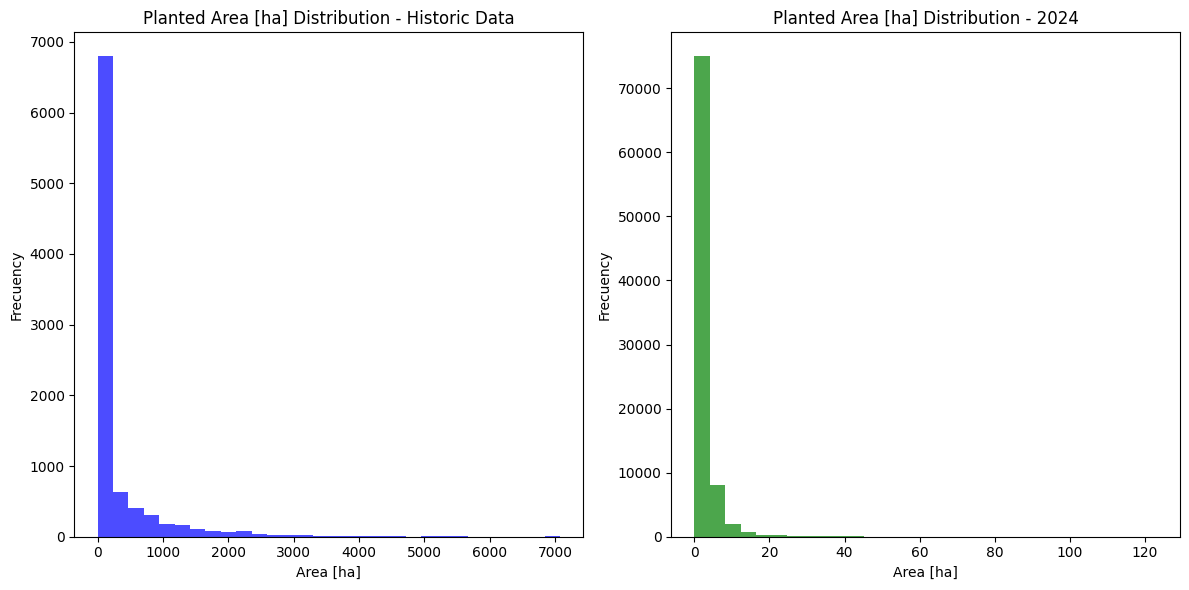

In [5]:
# Distribution of superficie_ha in df_historico and df_2024
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_historico['superficie_ha'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Planted Area [ha] Distribution - Historic Data')
plt.xlabel('Area [ha]')
plt.ylabel('Frecuency')
plt.subplot(1, 2, 2)
plt.hist(df_2024['superficie_plantada'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Planted Area [ha] Distribution - 2024')
plt.xlabel('Area [ha]')
plt.ylabel('Frecuency')
plt.tight_layout()
plt.show()



## Save into a SQLite Database

We are using the SQLite library to create two new tables and save the dataframes in them.

In [6]:
# Save into a SQLite database
conn = sqlite3.connect(SQLITE_DB)
df_historico.to_sql('historico_vinedos', conn, if_exists='replace', index=False)
df_2024.to_sql('vineyards_2024',conn, if_exists='replace', index=False)
conn.close()


## SQL Analysis: Historical Dataset (2012-2024)

The analysis in this section is all about the planted area of wine by province in order to plot a linechart in the range (2012-2024).

### Historical planted area in Argentina

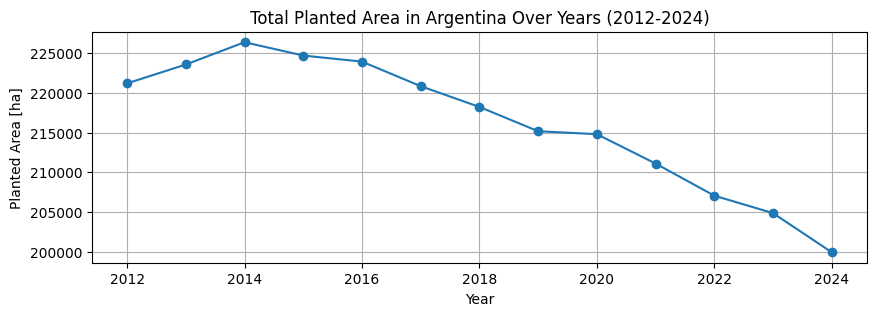

In [7]:
try:
    # Connect to the database
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT  anio AS year,
                SUM(superficie_ha) AS total_area_ha
        FROM historico_vinedos
        GROUP BY anio
        HAVING total_area_ha > 0
    """
    # Save the query result into a DataFrame
    df_historico_argentina = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

plt.figure(figsize=(10, 3))
plt.plot(df_historico_argentina['year'], df_historico_argentina['total_area_ha'], marker='o')
plt.title('Total Planted Area in Argentina Over Years (2012-2024)')
plt.xlabel('Year')
plt.ylabel('Planted Area [ha]')
plt.grid()
plt.show()

### Planted Area in Provinces by years

This query aims to get a dataframe with the historical planted area for each province.
Then, you can select one of those provinces and plot the evolution through the time

In [8]:
# Query for all provinces

try:
    # Connect to the database
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT  anio AS year,
                provincia_nombre AS province,
                SUM(superficie_ha) AS total_area_ha
        FROM historico_vinedos
        GROUP BY anio, provincia_nombre
        HAVING total_area_ha > 0
    """
    # Save the query result into a DataFrame
    df_provincias_historico = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()


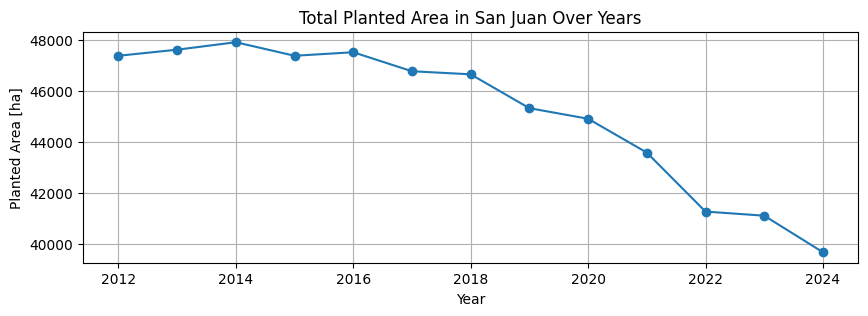

In [9]:
search_province = 'San Juan'
df_provin = df_provincias_historico[df_provincias_historico['province'] == search_province]
plt.figure(figsize=(10, 3))
plt.plot(df_provin['year'], df_provin['total_area_ha'], marker='o')
plt.title(f'Total Planted Area in {search_province} Over Years')
plt.xlabel('Year')
plt.ylabel('Planted Area [ha]')
plt.grid()
plt.show()

## SQL Analysis: 2024 Dataset

In the 2024 Dataset we can access to more information such as variety, color, year of plantation, etc.
We are using this information on the databse to query about the statistics of each province in Argentina.

### Filter columns of interest

In [17]:
# First look into the 2024 dataset

try:
    # Connect to database
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT provincia_nombre as province, 
                departamento_nombre as department, 
                localidad_nombre as locality, 
                variedad as variety, 
                color, 
                anio_plantacion as year_of_plantation, 
                superficie_plantada as planted_area_ha
        FROM vineyards_2024
    """
    df_2024_query = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

df_2024_query.head()

,province,department,locality,variety,color,year_of_plantation,planted_area_ha
0,Buenos Aires,Avellaneda,Sarandí,Isabella,tinta,1896,1.0341
1,Buenos Aires,Avellaneda,Villa Domínico,Isabella,tinta,1956,0.7365
2,Buenos Aires,Avellaneda,Villa Domínico,Isabella,tinta,1970,2.0000
3,Buenos Aires,Balcarce,Balcarce,Chardonnay,blanca,2013,0.6600
4,Buenos Aires,Balcarce,Balcarce,Sauvignon Blanc,blanca,2021,0.0704


### Variety and Color Analysis

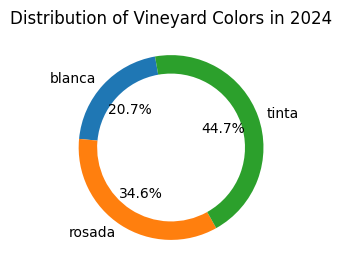

Note:
Blanca = White - Rosada = Rosé - Tinta = Red


In [18]:
# Color distribution in 2024 dataset
try:
    # Connect to database
    conn = sqlite3.connect(SQLITE_DB)
    # Query for percentage of colors in 2024 dataset
    query = """
        SELECT color, 
               COUNT(*) AS count,
               ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM vineyards_2024), 2) AS percentage
        FROM vineyards_2024
        GROUP BY color
    """
    df_2024_query_colors = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

# Ring plot for color distribution
colors = df_2024_query_colors['color']
counts = df_2024_query_colors['count']
percentages = df_2024_query_colors['percentage']
fig, ax = plt.subplots(figsize=(3, 3))
wedges, texts, autotexts = ax.pie(counts, labels=colors, autopct='%1.1f%%', startangle=100, wedgeprops=dict(width=0.2))
ax.set_title('Distribution of Vineyard Colors in 2024')
plt.show()

print("Note:")
print("Blanca = White - Rosada = Rosé - Tinta = Red")

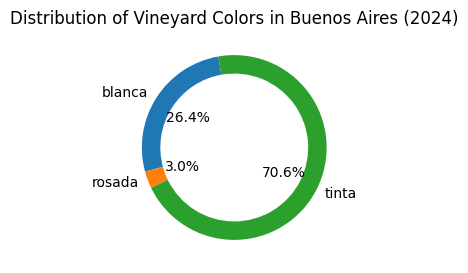

     color  count      province
0   blanca     88  Buenos Aires
20  rosada     10  Buenos Aires
39   tinta    235  Buenos Aires


In [19]:
# Color distribution for any Province in 2024 dataset
try:
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT  color,
                COUNT(*) AS count,
                provincia_nombre AS province
        FROM vineyards_2024
        GROUP BY color, provincia_nombre
    """
    df_province_color = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

# Query for a specific province:
pronviceOfInterest = 'Buenos Aires'

df_provincia_color = df_province_color[df_province_color['province'] == pronviceOfInterest]
# Ring plot for color distribution
colors = df_provincia_color['color']
counts = df_provincia_color['count']
fig, ax = plt.subplots(figsize=(3, 3))
wedges, texts, autotexts = ax.pie(counts, labels=colors, autopct='%1.1f%%', startangle=100, wedgeprops=dict(width=0.2))
ax.set_title(f'Distribution of Vineyard Colors in {pronviceOfInterest} (2024)')
plt.show()
print(df_provincia_color)
#print(df_province_color)

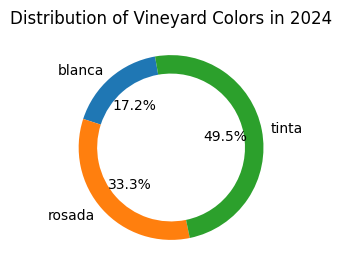

    color  count  percentage
0  blanca  10593       17.22
1  rosada  20461       33.26
2   tinta  30473       49.53


In [20]:
# Color distribution for Mendoza using subquery ---------------------------------------
try:
    conn = sqlite3.connect(SQLITE_DB)
    query = """
        SELECT  color,
                COUNT(*) AS count,
                ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM vineyards_2024 WHERE provincia_nombre = 'Mendoza'), 2) AS percentage
        FROM vineyards_2024
        WHERE provincia_nombre = 'Mendoza'
        GROUP BY color
    """
    df_mendoza_colors = pd.read_sql_query(query, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

# Ring plot for color distribution
colors_mendoza = df_mendoza_colors['color']
counts_mendoza = df_mendoza_colors['count']
fig, ax = plt.subplots(figsize=(3, 3))
wedges, texts, autotexts = ax.pie(counts_mendoza, labels=colors_mendoza, autopct='%1.1f%%', startangle=100, wedgeprops=dict(width=0.2))
ax.set_title('Distribution of Vineyard Colors in 2024')
plt.show()
print(df_mendoza_colors)

### General Data Analysis

In [ ]:
# Simple Analysis from Dataframe query
Total_varieties = df_2024_query['variety'].nunique()
Color_2024 = df_2024_query['color'].unique()
top3_locations = df_2024_query['locality'].value_counts().head(3)
top3_planted_area = df_2024_query.sort_values(by='planted_area_ha', ascending=False).head(3)[['province','locality', 'variety','color','planted_area_ha']]


print(f'Total unique varieties in 2024 dataset: {Total_varieties}')
print(f'Unique colors in 2024 dataset: {Color_2024}')
print("------------------------------------------------------------------")
print('Top 3 locations with most vineyards in 2024 dataset:')
print(top3_locations)
print("------------------------------------------------------------------")
print("Top 3 locations with highest planted area in 2024 dataset:")
print(top3_planted_area)
print("------------------------------------------------------------------")

2094
Total unique varieties in 2024 dataset: 186
Unique colors in 2024 dataset: ['tinta' 'blanca' 'rosada']
------------------------------------------------------------------
Top 3 locations with most vineyards in 2024 dataset:
locality
Montecaseros       2745
Chapanay           2094
Costa de Araujo    1940
Name: count, dtype: int64
------------------------------------------------------------------
Top 3 locations with highest planted area in 2024 dataset:
        province      locality             variety   color  planted_area_ha
590    Catamarca  Chañar Punco  Cabernet Sauvignon   tinta         123.2000
23271    Mendoza        Agrelo              Malbec   tinta         112.3952
33389    Mendoza   Campamentos   Torrontes Riojano  blanca         100.0000
------------------------------------------------------------------


C:\Users\valen\AppData\Local\Temp\ipykernel_27048\1500624543.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(top3_locations[1])


### TOP Planted Area by Geo

In [45]:
try:
    conn = sqlite3.connect(SQLITE_DB)
    queryPorvince = """
        SELECT provincia_nombre AS province,
                SUM(superficie_plantada) AS planted_area_ha
        FROM vineyards_2024
        GROUP BY provincia_nombre
        ORDER BY planted_area_ha DESC
        LIMIT 5
    """
    queryDepartment = """
        SELECT departamento_nombre AS department,
               SUM(superficie_plantada) AS planted_area_ha
        FROM vineyards_2024
        GROUP BY departamento_nombre
        ORDER BY planted_area_ha DESC
        LIMIT 5
    """
    queryLocality = """
        SELECT localidad_nombre AS locality,
               SUM(superficie_plantada) AS planted_area_ha
        FROM vineyards_2024
        GROUP BY localidad_nombre
        ORDER BY planted_area_ha DESC
        LIMIT 5
    """
    
    df_locality_area_planted = pd.read_sql_query(queryLocality, conn)
    df_department_area_planted = pd.read_sql_query(queryDepartment, conn)
    df_province_area_planted = pd.read_sql_query(queryPorvince, conn)
finally:
    if 'conn' in locals() and conn is not None:
        conn.close()

print("Top 5 Provinces by Planted Area in 2024:")
print(df_province_area_planted.head())
print("\n")
print("Top 5 Departments by Planted Area in 2024:")
print(df_department_area_planted.head())
print("\n")
print("Top 5 Localities by Planted Area in 2024:") 
print(df_locality_area_planted.head())

Top 5 Provinces by Planted Area in 2024:
    province  planted_area_ha
0    Mendoza      141142.7072
1   San Juan       39359.1544
2   La Rioja        6983.9396
3      Salta        3694.5372
4  Catamarca        2636.5696


Top 5 Departments by Planted Area in 2024:
      department  planted_area_ha
0     San Martín       23165.6869
1  Luján de Cuyo       15051.2132
2      Rivadavia       14046.4540
3        Lavalle       12159.3772
4     San Rafael       11306.8148


Top 5 Localities by Planted Area in 2024:
       locality  planted_area_ha
0  Montecaseros        5775.9323
1        Agrelo        5628.9509
2   La Consulta        4878.2636
3      Chapanay        4441.9602
4     Ugarteche        4095.8090


### Year of Plantation Distribution

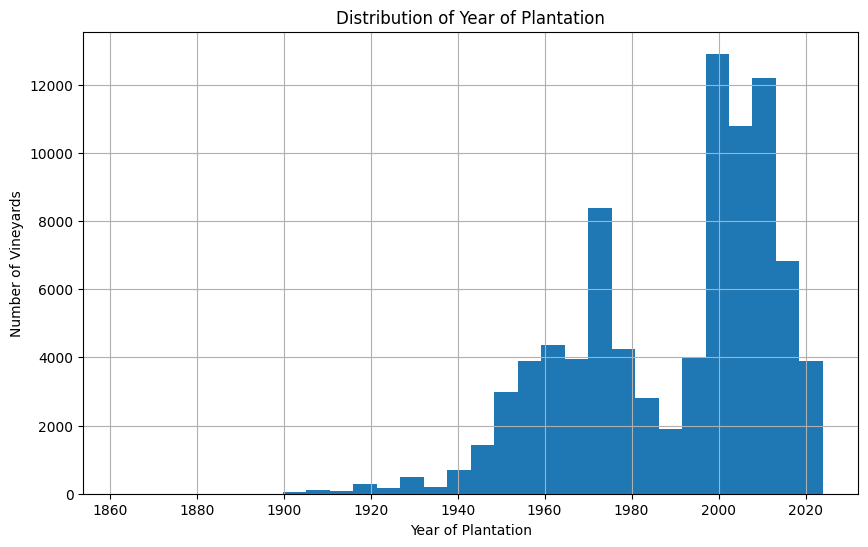

In [25]:
# Year of Plantation Distribution
plt.figure(figsize=(10,6))
df_2024_query['year_of_plantation'].dropna().astype(int).hist(bins=30)
plt.title('Distribution of Year of Plantation')
plt.xlabel('Year of Plantation')
plt.ylabel('Number of Vineyards')
plt.show()


## Create new tables in DB for exporting